In [ ]:
from gfn_environments.single_color_ramp import *

import torch


# forward policy

EPOCHS = 100

REPLAY_BUFFER_SIZE = 1000
TRAJECTORY_LEN = 10

from gfn_environments.single_color_ramp import v2StepWEnv

blender_api = BlenderTerrainAPI()
# this is what we use to get "tensorfied" env actions
env_serializer = v2StepWEnv()

import random

def random_polocy(env_s:v2StepWEnv, num_samples):
    """
    used to prefill the buffer.
    will sample random action
    and terminate them with stop
    """
    num_actions = len(env_s.tensor_to_action)

    traj_list= []

    action_tensors = list(env_s.tensor_to_action.keys())
    heightmaps = []
    for i in range(num_samples):
        blender_api.reset_env()
        _trajectory= []
        for step in range(TRAJECTORY_LEN-1):
            _random_action = random.sample(action_tensors,1)[0]

            _one_hot  = torch.zeros(num_actions)
            _one_hot[_random_action] = 1.0

            env_s.execute_one_hot_action(blender_api,_one_hot)

            _trajectory.append(_one_hot)

        # I just know that the stop action is the last one

        _trajectory.append(action_tensors[-1])
        _heightmap = blender_api.get_heightmap()
        heightmaps.append(_heightmap)
        traj_list.append(_trajectory)

    return traj_list, heightmaps


import pandas as pd
import torch

replay_buffer_cap = 500
# prefill the replay buffer
prefill_trajectories, prefill_heightmaps = random_polocy(env_serializer, replay_buffer_cap)

replay_buffer = pd.DataFrame()
replay_buffer['trajectorys'] = prefill_trajectories
replay_buffer['heightmaps'] = prefill_heightmaps

# Add range columns
def get_range(tensor_list):
    # Flatten all tensors in the list and find min/max
    all_values = torch.cat([t.flatten() for t in tensor_list])
    return f"[{all_values.min().item():.4f}, {all_values.max().item():.4f}]"

replay_buffer['heightmaps_range'] = replay_buffer['heightmaps'].apply(get_range)

print(replay_buffer)

In [8]:
import pandas as pd
import torch
import numpy as np

replay_buffer_cap = 5
# prefill the replay buffer
prefill_trajectories, prefill_heightmaps = random_polocy(env_serializer, replay_buffer_cap)

replay_buffer = pd.DataFrame()
replay_buffer['trajectorys'] = prefill_trajectories
replay_buffer['heightmaps'] = prefill_heightmaps

# Function to get min, max, and range
def get_range_stats(tensor_list):
    all_values = torch.cat([t.flatten() for t in tensor_list])
    min_val = all_values.min().item()
    max_val = all_values.max().item()
    range_val = max_val - min_val
    return min_val, max_val, range_val


replay_buffer[['height_min', 'height_max', 'height_range']] = replay_buffer['heightmaps'].apply(
    lambda x: pd.Series(get_range_stats(x))
)


print("\n" + "=" * 60)
print("HEIGHTMAP RANGES - Percentile Analysis")
print("=" * 60)
height_percentiles = replay_buffer['height_range'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
print(height_percentiles)
print(f"\n10th percentile (small range): {replay_buffer['height_range'].quantile(0.1):.4f}")
print(f"50th percentile (median): {replay_buffer['height_range'].quantile(0.5):.4f}")
print(f"90th percentile (large range): {replay_buffer['height_range'].quantile(0.9):.4f}")

✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

HEIGHTMAP RANGES - Percentile Analysis
count    5.000000
mean     0.686061
std      0.248324
min      0.252796
10%      0.438314
25%      0.716591
50%      0.792420
75%      0.796990
90%      0.841701
max      0.871508
Name: height_range, dtype: float64

10th percentile (small range): 0.4383
50th percentile (median): 0.7924
90th percentile (large range): 0.8417


In [18]:
import pandas as pd
import torch
import numpy as np

replay_buffer_cap = 1000
# prefill the replay buffer
prefill_trajectories, prefill_heightmaps = random_polocy(env_serializer, replay_buffer_cap)

replay_buffer = pd.DataFrame()
replay_buffer['trajectorys'] = prefill_trajectories
replay_buffer['heightmaps'] = prefill_heightmaps

# Function to get min, max, and range
def get_range_stats(tensor_list):
    all_values = torch.cat([t.flatten() for t in tensor_list])
    min_val = all_values.min().item()
    max_val = all_values.max().item()
    range_val = max_val - min_val
    return min_val, max_val, range_val

replay_buffer[['height_min', 'height_max', 'height_range']] = replay_buffer['heightmaps'].apply(
    lambda x: pd.Series(get_range_stats(x))
)

# Calculate percentile for each heightmap range
def calculate_percentile(value, series):
    """Calculate what percentile a value is in a series"""
    return (series < value).sum() / len(series) * 100

replay_buffer['height_range_percentile'] = replay_buffer['height_range'].apply(
    lambda x: calculate_percentile(x, replay_buffer['height_range'])
)

# Reward function based on percentiles
def get_reward(percentile):
    """
    Reward based on percentile:
    - Below 50th percentile: r = 0
    - 50th to 80th percentile: r = 0.5
    - 80th percentile and above: r = 1.0
    """
    if percentile < 50:
        return 0.0
    elif percentile < 80:
        return 0.5
    else:
        return 1.0

replay_buffer['reward'] = replay_buffer['height_range_percentile'].apply(get_reward)

print("\n" + "=" * 60)
print("HEIGHTMAP RANGES - Percentile Analysis")
print("=" * 60)
height_percentiles = replay_buffer['height_range'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
print(height_percentiles)
print(f"\n10th percentile (small range): {replay_buffer['height_range'].quantile(0.1):.4f}")
print(f"50th percentile (median): {replay_buffer['height_range'].quantile(0.5):.4f}")
print(f"90th percentile (large range): {replay_buffer['height_range'].quantile(0.9):.4f}")

print("\n" + "=" * 60)
print("REPLAY BUFFER WITH REWARDS")
print("=" * 60)
print(replay_buffer[['height_range', 'height_range_percentile', 'reward']])

print("\n" + "=" * 60)
print("REWARD DISTRIBUTION")
print("=" * 60)
print(replay_buffer['reward'].value_counts().sort_index())
print(f"\nMean Reward: {replay_buffer['reward'].mean():.2f}")

✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

In [19]:
len(replay_buffer["heightmaps"])

1000


Detected action_dim: 35
First trajectory length: 10

TRAINING GFLOWNET ON TRAJECTORIES
Number of trajectories in replay buffer: 1000
Action space size (one-hot dim): 35

Reward distribution:
  Reward 0.0: 500 trajectories
  Reward 0.5: 300 trajectories
  Reward 1.0: 200 trajectories

Epoch 100/1000
  Average TB Loss: 0.1610
  Log Z: 0.2024
  Z: 1.2243
  Sum of rewards: 350.0000

Epoch 200/1000
  Average TB Loss: 0.0998
  Log Z: 0.2787
  Z: 1.3214
  Sum of rewards: 350.0000

Epoch 300/1000
  Average TB Loss: 0.2035
  Log Z: 0.3836
  Z: 1.4676
  Sum of rewards: 350.0000

Epoch 400/1000
  Average TB Loss: 0.1092
  Log Z: 0.4498
  Z: 1.5680
  Sum of rewards: 350.0000

Epoch 500/1000
  Average TB Loss: 0.0831
  Log Z: 0.5140
  Z: 1.6720
  Sum of rewards: 350.0000

Epoch 600/1000
  Average TB Loss: 0.0695
  Log Z: 0.5569
  Z: 1.7452
  Sum of rewards: 350.0000

Epoch 700/1000
  Average TB Loss: 0.0612
  Log Z: 0.6081
  Z: 1.8370
  Sum of rewards: 350.0000

Epoch 800/1000
  Average TB Loss: 0

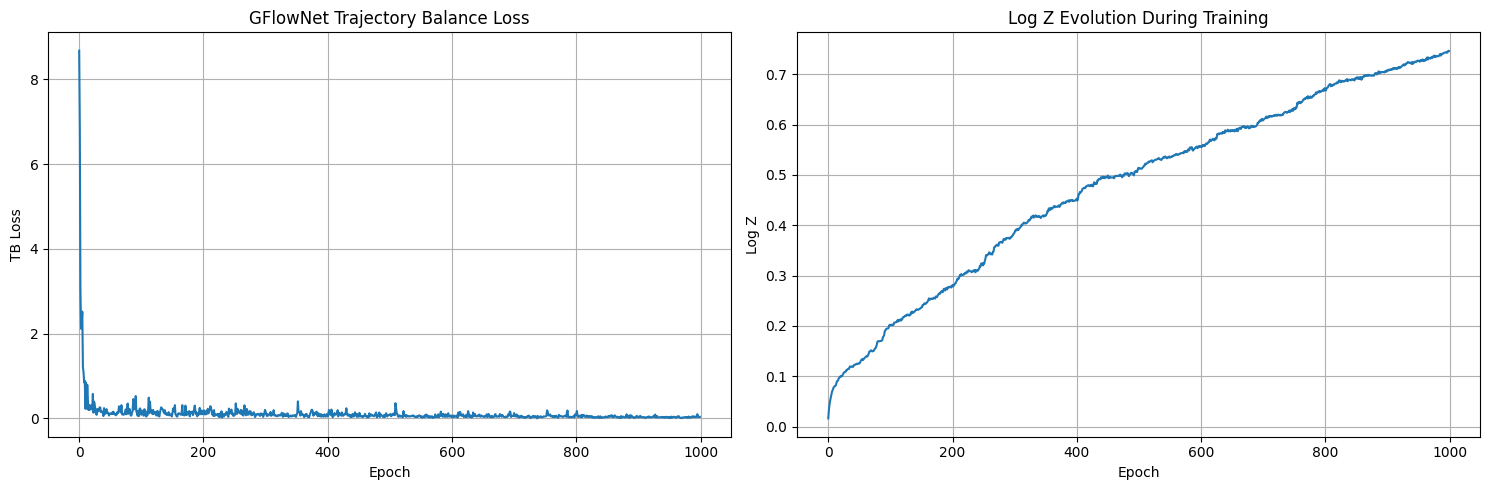

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical

# GFlowNet Model that takes trajectory history as state
class GFlowNet(nn.Module):
    def __init__(self, trajectory_encoder_dim, hidden_dim=128, action_dim=None):
        super(GFlowNet, self).__init__()
        self.action_dim = action_dim
        
        # Forward policy network (trajectory state -> action probabilities)
        self.forward_policy = nn.Sequential(
            nn.Linear(trajectory_encoder_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_dim)
        )
        
        # Backward policy (for TB loss)
        self.backward_policy = nn.Sequential(
            nn.Linear(trajectory_encoder_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_dim)
        )
        
        # Log Z (partition function) - learnable parameter
        self.log_Z = nn.Parameter(torch.zeros(1))
    
    def forward_probs(self, state):
        logits = self.forward_policy(state)
        return torch.softmax(logits, dim=-1)
    
    def backward_probs(self, state):
        logits = self.backward_policy(state)
        return torch.softmax(logits, dim=-1)

# Trajectory Encoder - encodes sequence of one-hot tensors
class TrajectoryEncoder(nn.Module):
    def __init__(self, action_dim, hidden_dim=64, output_dim=64):
        super(TrajectoryEncoder, self).__init__()
        self.action_dim = action_dim
        
        # LSTM to encode trajectory history (sequence of one-hot vectors)
        self.lstm = nn.LSTM(action_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Project LSTM output to desired dimension
        self.projection = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, trajectory):
        # trajectory: list of one-hot tensors
        if len(trajectory) == 0:
            # Return initial state encoding (zeros)
            return torch.zeros(1, self.projection.out_features)
        
        # Stack tensors into a sequence [seq_len, action_dim]
        traj_tensor = torch.stack(trajectory).unsqueeze(0).float()  # [1, seq_len, action_dim]
        
        # Run through LSTM
        lstm_out, (hidden, _) = self.lstm(traj_tensor)
        
        # Use last output
        last_output = lstm_out[:, -1, :]  # [1, hidden_dim*2]
        
        # Project to output dimension
        state = self.projection(last_output)
        return state

# Training function with trajectory sampling
def train_gflownet(replay_buffer, num_epochs=1000, lr=1e-3):
    # Infer action_dim from first trajectory
    first_traj = replay_buffer['trajectorys'].iloc[0]
    
    # Handle the case where last element might be an integer (stop action index)
    first_step = first_traj[0]
    if isinstance(first_step, torch.Tensor):
        action_dim = len(first_step)
    else:
        # If it's an integer, we need to figure out action_dim from env
        action_dim = len(env_serializer.tensor_to_action)
    
    state_dim = 64
    
    print(f"\nDetected action_dim: {action_dim}")
    print(f"First trajectory length: {len(first_traj)}")
    
    # Initialize models
    trajectory_encoder = TrajectoryEncoder(
        action_dim=action_dim,
        hidden_dim=64,
        output_dim=state_dim
    )
    gflownet = GFlowNet(
        trajectory_encoder_dim=state_dim, 
        action_dim=action_dim
    )
    
    # Optimizer
    params = list(trajectory_encoder.parameters()) + list(gflownet.parameters())
    optimizer = optim.Adam(params, lr=lr)
    
    # Convert trajectories to proper format (all tensors)
    def normalize_trajectory(traj):
        normalized = []
        for step in traj:
            if isinstance(step, torch.Tensor):
                if step.dim() == 0:  # scalar tensor (index)
                    one_hot = torch.zeros(action_dim)
                    one_hot[step.item()] = 1.0
                    normalized.append(one_hot)
                else:  # already one-hot
                    normalized.append(step)
            elif isinstance(step, int):  # integer index
                one_hot = torch.zeros(action_dim)
                one_hot[step] = 1.0
                normalized.append(one_hot)
        return normalized
    
    # Get trajectories and rewards from replay buffer
    replay_trajectories = [normalize_trajectory(traj) for traj in replay_buffer['trajectorys'].tolist()]
    rewards = torch.tensor(replay_buffer['reward'].values, dtype=torch.float32)
    
    print("\n" + "=" * 60)
    print("TRAINING GFLOWNET ON TRAJECTORIES")
    print("=" * 60)
    print(f"Number of trajectories in replay buffer: {len(replay_trajectories)}")
    print(f"Action space size (one-hot dim): {action_dim}")
    print(f"\nReward distribution:")
    reward_counts = {0.0: 0, 0.5: 0, 1.0: 0}
    for r in rewards:
        reward_counts[r.item()] = reward_counts.get(r.item(), 0) + 1
    for r_val, count in reward_counts.items():
        print(f"  Reward {r_val}: {count} trajectories")
    
    losses = []
    log_z_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_processed = 0
        
        # Sample a batch of trajectories from replay buffer
        batch_size = min(len(replay_trajectories), 32)
        batch_indices = torch.randint(0, len(replay_trajectories), (batch_size,))
        
        for idx in batch_indices:
            trajectory = replay_trajectories[idx]
            reward = rewards[idx]
            
            if reward == 0:
                continue  # Skip zero reward trajectories
            
            optimizer.zero_grad()
            
            # Forward pass through trajectory
            log_pf_total = 0
            log_pb_total = 0
            
            current_traj = []
            for step_idx, one_hot in enumerate(trajectory):
                # Encode current trajectory state
                state = trajectory_encoder(current_traj)
                
                # Get forward probabilities
                pf = gflownet.forward_probs(state)
                
                # Get the action index from one-hot
                action_idx = torch.argmax(one_hot).item()
                
                log_pf = torch.log(pf[0, action_idx] + 1e-10)
                log_pf_total += log_pf
                
                # Add action to trajectory
                current_traj.append(one_hot)
                
                # Get backward probabilities (for TB loss)
                if len(current_traj) > 1:
                    state_next = trajectory_encoder(current_traj)
                    pb = gflownet.backward_probs(state_next)
                    prev_action_idx = torch.argmax(current_traj[-2]).item()
                    log_pb = torch.log(pb[0, prev_action_idx] + 1e-10)
                    log_pb_total += log_pb
            
            # Trajectory Balance Loss: log Z + log P_F(τ) = log R(τ) + log P_B(τ)
            log_reward = torch.log(reward + 1e-10)
            tb_loss = (gflownet.log_Z + log_pf_total - log_reward - log_pb_total) ** 2
            
            tb_loss.backward()
            optimizer.step()
            
            epoch_loss += tb_loss.item()
            num_processed += 1
        
        if num_processed > 0:
            avg_loss = epoch_loss / num_processed
            losses.append(avg_loss)
            log_z_history.append(gflownet.log_Z.item())
        
            if (epoch + 1) % 100 == 0:
                print(f"\nEpoch {epoch + 1}/{num_epochs}")
                print(f"  Average TB Loss: {avg_loss:.4f}")
                print(f"  Log Z: {gflownet.log_Z.item():.4f}")
                print(f"  Z: {torch.exp(gflownet.log_Z).item():.4f}")
                print(f"  Sum of rewards: {rewards.sum().item():.4f}")
    
    return trajectory_encoder, gflownet, losses, log_z_history, replay_trajectories, action_dim

# Sample trajectories from the trained GFlowNet
def sample_trajectories_from_gflownet(trajectory_encoder, gflownet, num_samples=100, 
                                     trajectory_length=10, action_dim=None):
    sampled_trajectories = []
    
    print("\n" + "=" * 60)
    print(f"SAMPLING {num_samples} TRAJECTORIES FROM GFLOWNET")
    print("=" * 60)
    print(f"Log Z: {gflownet.log_Z.item():.4f}")
    print(f"Z (partition function): {torch.exp(gflownet.log_Z).item():.4f}")
    
    with torch.no_grad():
        for i in range(num_samples):
            trajectory = []
            
            for step in range(trajectory_length):
                # Encode current trajectory
                state = trajectory_encoder(trajectory)
                
                # Get action probabilities
                action_probs = gflownet.forward_probs(state).squeeze()
                
                # Sample action
                action_idx = Categorical(action_probs).sample().item()
                
                # Convert to one-hot
                one_hot = torch.zeros(action_dim)
                one_hot[action_idx] = 1.0
                
                trajectory.append(one_hot)
            
            sampled_trajectories.append(trajectory)
            
            if i < 10:  # Print first 10
                actions = [torch.argmax(oh).item() for oh in trajectory]
                print(f"Sample {i+1}: {actions}")
    
    return sampled_trajectories

# Check if sampled trajectories match replay buffer
def check_trajectory_matches(sampled_trajectories, replay_trajectories, replay_buffer):
    print("\n" + "=" * 60)
    print("CHECKING TRAJECTORY MATCHES WITH REPLAY BUFFER")
    print("=" * 60)
    
    matches = []
    
    for i, sampled_traj in enumerate(sampled_trajectories):
        for j, replay_traj in enumerate(replay_trajectories):
            # Check if lengths match
            if len(sampled_traj) != len(replay_traj):
                continue
                
            # Check if all steps match
            match = True
            for s, r in zip(sampled_traj, replay_traj):
                if not torch.equal(s, r):
                    match = False
                    break
            
            if match:
                matches.append((i, j))
                reward = replay_buffer.iloc[j]['reward']
                print(f"✓ Sampled trajectory {i} matches replay buffer index {j} (reward={reward:.2f})")
                break
    
    match_rate = len(matches) / len(sampled_trajectories) * 100
    print(f"\nMatch rate: {len(matches)}/{len(sampled_trajectories)} ({match_rate:.1f}%)")
    
    # Count matches by reward level
    if len(matches) > 0:
        matched_rewards = [replay_buffer.iloc[j]['reward'] for _, j in matches]
        print(f"\nMatched trajectories by reward:")
        print(f"  Reward 0.0: {matched_rewards.count(0.0)}")
        print(f"  Reward 0.5: {matched_rewards.count(0.5)}")
        print(f"  Reward 1.0: {matched_rewards.count(1.0)}")
    else:
        print("\nNo exact matches found. GFlowNet is exploring new trajectories!")
        print("This is expected - GFlowNet should generalize beyond the replay buffer.")
    
    return matches

# Train the GFlowNet
trajectory_encoder, gflownet, losses, log_z_history, replay_trajectories, action_dim = train_gflownet(
    replay_buffer, 
    num_epochs=1000, 
    lr=1e-3
)

# Sample 100 trajectories
sampled_trajectories = sample_trajectories_from_gflownet(
    trajectory_encoder,
    gflownet,
    num_samples=100,
    trajectory_length=TRAJECTORY_LEN,
    action_dim=action_dim
)

# Check matches
matches = check_trajectory_matches(sampled_trajectories, replay_trajectories, replay_buffer)

# Plot training curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('TB Loss')
axes[0].set_title('GFlowNet Trajectory Balance Loss')
axes[0].grid(True)

# Plot log Z
axes[1].plot(log_z_history)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Log Z')
axes[1].set_title('Log Z Evolution During Training')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Action dim: 35
Max trajectory length: 10
Trajectory state dim: 350

TRAINING GFLOWNET ON TRAJECTORIES
Number of trajectories in replay buffer: 1000

Reward distribution in replay buffer:
  Reward 0.0: 500 trajectories (50.0%)
  Reward 0.5: 300 trajectories (30.0%)
  Reward 1.0: 200 trajectories (20.0%)

Epoch 100/10000
  Average TB Loss: 0.0503
  Log Z: 0.2190
  Z: 1.2449
  Sum of non-zero rewards: 350.0000

Epoch 200/10000
  Average TB Loss: 0.0600
  Log Z: 0.2936
  Z: 1.3413
  Sum of non-zero rewards: 350.0000

Epoch 300/10000
  Average TB Loss: 0.0875
  Log Z: 0.3539
  Z: 1.4247
  Sum of non-zero rewards: 350.0000

Epoch 400/10000
  Average TB Loss: 0.0722
  Log Z: 0.4156
  Z: 1.5152
  Sum of non-zero rewards: 350.0000

Epoch 500/10000
  Average TB Loss: 0.0385
  Log Z: 0.4412
  Z: 1.5545
  Sum of non-zero rewards: 350.0000

Epoch 600/10000
  Average TB Loss: 0.0668
  Log Z: 0.4846
  Z: 1.6236
  Sum of non-zero rewards: 350.0000

Epoch 700/10000
  Average TB Loss: 0.0111
  Log Z: 0

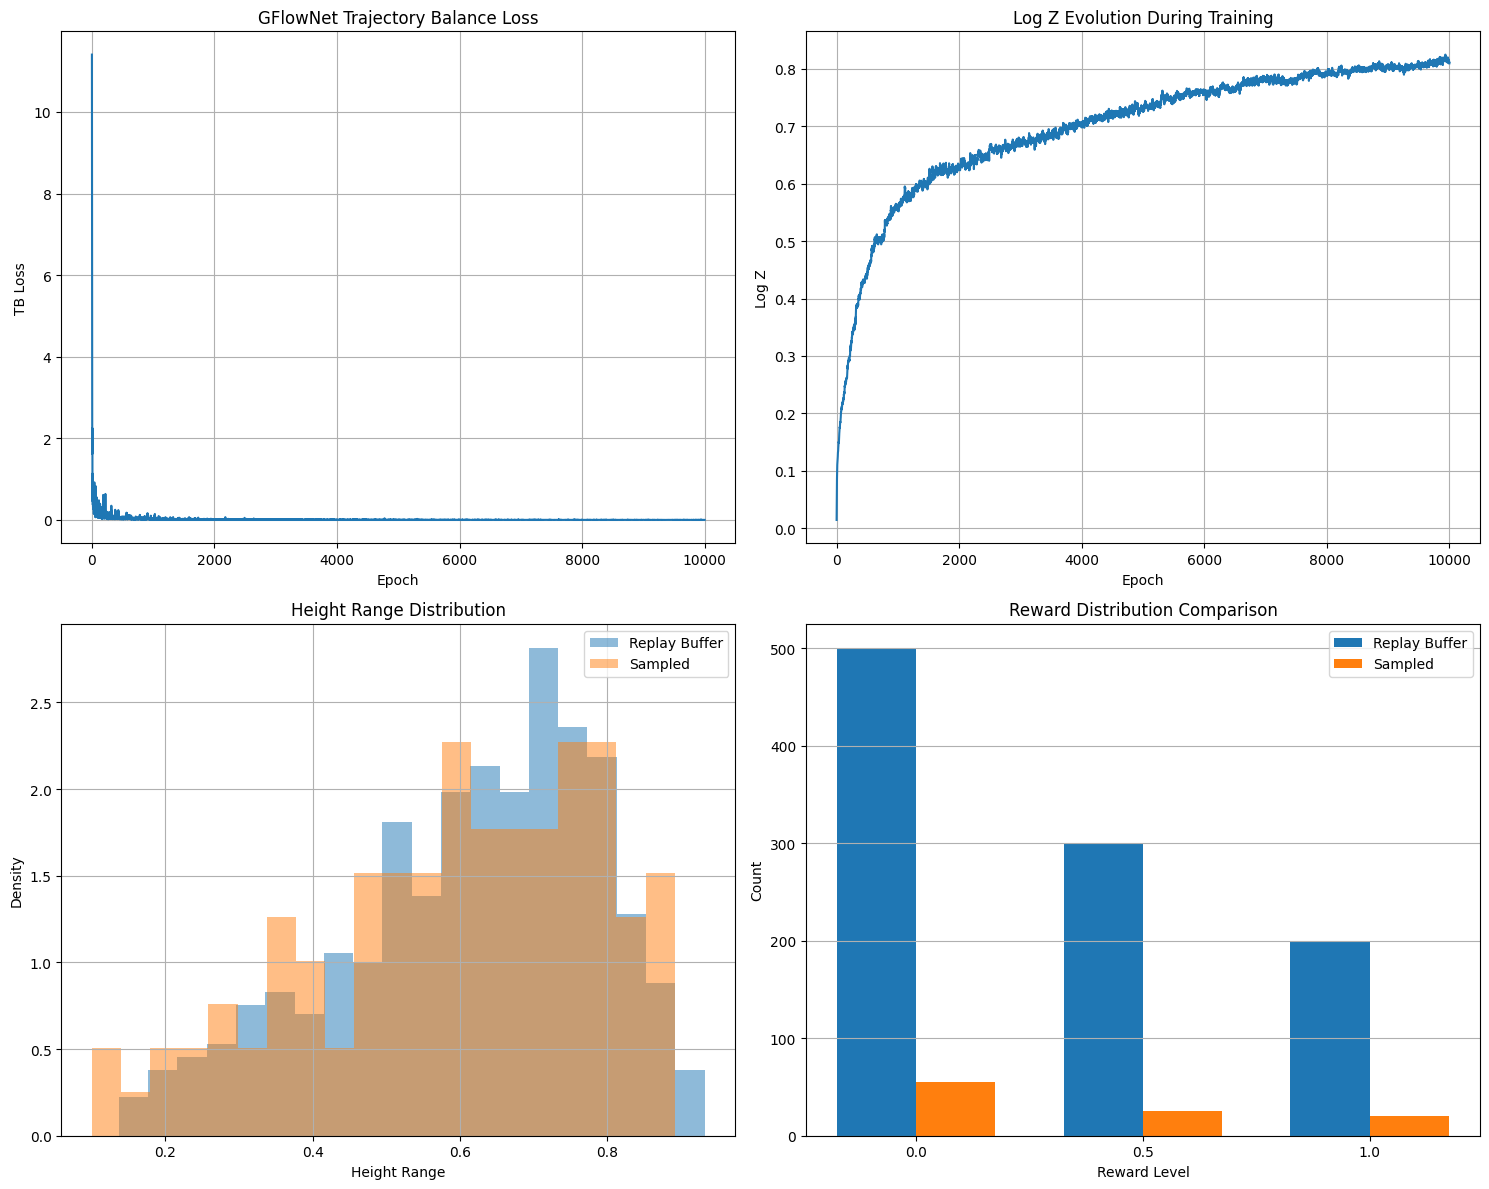

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical

# GFlowNet that takes the trajectory directly as input
class GFlowNet(nn.Module):
    def __init__(self, trajectory_dim, hidden_dim=128, action_dim=None):
        super(GFlowNet, self).__init__()
        self.action_dim = action_dim
        self.trajectory_dim = trajectory_dim
        
        # Forward policy network (flattened trajectory -> action logits)
        self.forward_policy = nn.Sequential(
            nn.Linear(trajectory_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Backward policy (for TB loss)
        self.backward_policy = nn.Sequential(
            nn.Linear(trajectory_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Log Z (partition function) - learnable parameter
        self.log_Z = nn.Parameter(torch.zeros(1))
    
    def forward_logits(self, state):
        return self.forward_policy(state)
    
    def forward_probs(self, state):
        logits = self.forward_logits(state)
        return torch.softmax(logits, dim=-1)
    
    def backward_logits(self, state):
        return self.backward_policy(state)
    
    def backward_probs(self, state):
        logits = self.backward_logits(state)
        return torch.softmax(logits, dim=-1)

def trajectory_to_state(trajectory, max_length, action_dim):
    """
    Convert trajectory (list of one-hot tensors) to a zero-padded flat state
    """
    state = torch.zeros(max_length * action_dim)
    
    for i, one_hot in enumerate(trajectory):
        if i >= max_length:
            break
        start_idx = i * action_dim
        end_idx = start_idx + action_dim
        state[start_idx:end_idx] = one_hot
    
    return state

def train_gflownet(replay_buffer, num_epochs=10000, lr=1e-3, max_trajectory_length=10):
    # Infer action_dim from first trajectory
    first_traj = replay_buffer['trajectorys'].iloc[0]
    first_step = first_traj[0]
    
    if isinstance(first_step, torch.Tensor):
        action_dim = len(first_step)
    else:
        action_dim = len(env_serializer.tensor_to_action)
    
    trajectory_dim = max_trajectory_length * action_dim
    
    print(f"\nAction dim: {action_dim}")
    print(f"Max trajectory length: {max_trajectory_length}")
    print(f"Trajectory state dim: {trajectory_dim}")
    
    # Initialize model
    gflownet = GFlowNet(
        trajectory_dim=trajectory_dim,
        action_dim=action_dim
    )
    
    # Optimizer
    optimizer = optim.Adam(gflownet.parameters(), lr=lr)
    
    # Convert trajectories to proper format
    def normalize_trajectory(traj):
        normalized = []
        for step in traj:
            if isinstance(step, torch.Tensor):
                if step.dim() == 0:  # scalar tensor (index)
                    one_hot = torch.zeros(action_dim)
                    one_hot[step.item()] = 1.0
                    normalized.append(one_hot)
                else:  # already one-hot
                    normalized.append(step)
            elif isinstance(step, int):  # integer index
                one_hot = torch.zeros(action_dim)
                one_hot[step] = 1.0
                normalized.append(one_hot)
        return normalized
    
    # Get trajectories and rewards
    replay_trajectories = [normalize_trajectory(traj) for traj in replay_buffer['trajectorys'].tolist()]
    rewards = torch.tensor(replay_buffer['reward'].values, dtype=torch.float32)
    
    print("\n" + "=" * 60)
    print("TRAINING GFLOWNET ON TRAJECTORIES")
    print("=" * 60)
    print(f"Number of trajectories in replay buffer: {len(replay_trajectories)}")
    print(f"\nReward distribution in replay buffer:")
    reward_counts = {}
    for r in rewards:
        r_val = r.item()
        reward_counts[r_val] = reward_counts.get(r_val, 0) + 1
    for r_val, count in sorted(reward_counts.items()):
        print(f"  Reward {r_val}: {count} trajectories ({count/len(rewards)*100:.1f}%)")
    
    losses = []
    log_z_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_processed = 0
        
        # Sample a batch of trajectories from replay buffer
        batch_size = min(len(replay_trajectories), 32)
        batch_indices = torch.randint(0, len(replay_trajectories), (batch_size,))
        
        for idx in batch_indices:
            trajectory = replay_trajectories[idx]
            reward = rewards[idx]
            
            if reward == 0:
                continue  # Skip zero reward trajectories
            
            optimizer.zero_grad()
            
            # Forward pass through trajectory
            log_pf_total = 0
            log_pb_total = 0
            
            current_traj = []
            
            for step_idx, one_hot in enumerate(trajectory):
                # Convert current trajectory to state (zero-padded)
                state = trajectory_to_state(current_traj, max_trajectory_length, action_dim).unsqueeze(0)
                
                # Get forward logits and probabilities
                logits = gflownet.forward_logits(state)
                pf = torch.softmax(logits, dim=-1)
                
                # Get the action index from one-hot
                action_idx = torch.argmax(one_hot).item()
                
                # Log probability of taking this action
                log_pf = torch.log(pf[0, action_idx] + 1e-10)
                log_pf_total += log_pf
                
                # Add action to trajectory (set the action bit for current step)
                current_traj.append(one_hot)
                
                # Backward policy (for TB loss)
                if len(current_traj) > 1:
                    state_next = trajectory_to_state(current_traj, max_trajectory_length, action_dim).unsqueeze(0)
                    pb_logits = gflownet.backward_logits(state_next)
                    pb = torch.softmax(pb_logits, dim=-1)
                    prev_action_idx = torch.argmax(current_traj[-2]).item()
                    log_pb = torch.log(pb[0, prev_action_idx] + 1e-10)
                    log_pb_total += log_pb
            
            # Trajectory Balance Loss: log Z + log P_F(τ) = log R(τ) + log P_B(τ)
            log_reward = torch.log(reward + 1e-10)
            tb_loss = (gflownet.log_Z + log_pf_total - log_reward - log_pb_total) ** 2
            
            tb_loss.backward()
            optimizer.step()
            
            epoch_loss += tb_loss.item()
            num_processed += 1
        
        if num_processed > 0:
            avg_loss = epoch_loss / num_processed
            losses.append(avg_loss)
            log_z_history.append(gflownet.log_Z.item())
        
            if (epoch + 1) % 100 == 0:
                print(f"\nEpoch {epoch + 1}/{num_epochs}")
                print(f"  Average TB Loss: {avg_loss:.4f}")
                print(f"  Log Z: {gflownet.log_Z.item():.4f}")
                print(f"  Z: {torch.exp(gflownet.log_Z).item():.4f}")
                print(f"  Sum of non-zero rewards: {rewards[rewards > 0].sum().item():.4f}")
    
    return gflownet, losses, log_z_history, action_dim, max_trajectory_length

# Sample trajectories and EVALUATE them in the environment
def sample_and_evaluate_trajectories(gflownet, blender_api, env_serializer,
                                     num_samples=100, trajectory_length=10, action_dim=None):
    sampled_trajectories = []
    sampled_heightmaps = []
    sampled_height_ranges = []
    
    print("\n" + "=" * 60)
    print(f"SAMPLING {num_samples} TRAJECTORIES AND EVALUATING THEM")
    print("=" * 60)
    print(f"Log Z: {gflownet.log_Z.item():.4f}")
    print(f"Z (partition function): {torch.exp(gflownet.log_Z).item():.4f}")
    
    with torch.no_grad():
        for i in range(num_samples):
            # Reset environment
            blender_api.reset_env()
            trajectory = []
            
            # Sample trajectory step by step
            for step in range(trajectory_length):
                # Convert current trajectory to state (zero-padded)
                state = trajectory_to_state(trajectory, trajectory_length, action_dim).unsqueeze(0)
                
                # Get action logits
                logits = gflownet.forward_logits(state)
                action_probs = torch.softmax(logits, dim=-1).squeeze()
                
                # Sample action
                action_idx = Categorical(action_probs).sample().item()
                
                # Convert to one-hot
                one_hot = torch.zeros(action_dim)
                one_hot[action_idx] = 1.0
                
                # Execute action in environment (except for last step if it's stop)
                if step < trajectory_length - 1:
                    env_serializer.execute_one_hot_action(blender_api, one_hot)
                
                # Set the action bit for the current step in the trajectory
                trajectory.append(one_hot)
            
            # Get final heightmap
            heightmap = blender_api.get_heightmap()
            
            # Calculate height range
            all_values = torch.cat([t.flatten() for t in heightmap])
            height_range = all_values.max().item() - all_values.min().item()
            
            sampled_trajectories.append(trajectory)
            sampled_heightmaps.append(heightmap)
            sampled_height_ranges.append(height_range)
            
            if i < 10:  # Print first 10
                actions = [torch.argmax(oh).item() for oh in trajectory]
                print(f"Sample {i+1}: actions={actions}, height_range={height_range:.4f}")
    
    return sampled_trajectories, sampled_heightmaps, sampled_height_ranges

# Check for exact matches
def check_trajectory_matches(sampled_trajectories, replay_buffer):
    print("\n" + "=" * 60)
    print("CHECKING FOR EXACT TRAJECTORY MATCHES")
    print("=" * 60)
    
    replay_trajectories = []
    for traj in replay_buffer['trajectorys'].tolist():
        normalized = []
        for step in traj:
            if isinstance(step, torch.Tensor):
                if step.dim() == 0:
                    one_hot = torch.zeros(len(env_serializer.tensor_to_action))
                    one_hot[step.item()] = 1.0
                    normalized.append(one_hot)
                else:
                    normalized.append(step)
            elif isinstance(step, int):
                one_hot = torch.zeros(len(env_serializer.tensor_to_action))
                one_hot[step] = 1.0
                normalized.append(one_hot)
        replay_trajectories.append(normalized)
    
    matches = []
    for i, sampled_traj in enumerate(sampled_trajectories):
        for j, replay_traj in enumerate(replay_trajectories):
            if len(sampled_traj) != len(replay_traj):
                continue
            
            match = True
            for s, r in zip(sampled_traj, replay_traj):
                if not torch.equal(s, r):
                    match = False
                    break
            
            if match:
                matches.append((i, j))
                reward = replay_buffer.iloc[j]['reward']
                print(f"✓ Sampled trajectory {i} EXACTLY matches replay buffer index {j} (reward={reward:.2f})")
                break
    
    match_rate = len(matches) / len(sampled_trajectories) * 100
    print(f"\nExact match rate: {len(matches)}/{len(sampled_trajectories)} ({match_rate:.1f}%)")
    
    if len(matches) > 0:
        matched_rewards = [replay_buffer.iloc[j]['reward'] for _, j in matches]
        print(f"\nMatched trajectories by reward:")
        print(f"  Reward 0.0: {matched_rewards.count(0.0)}")
        print(f"  Reward 0.5: {matched_rewards.count(0.5)}")
        print(f"  Reward 1.0: {matched_rewards.count(1.0)}")
    
    return matches

# Compare reward distributions
def compare_distributions(replay_buffer, sampled_height_ranges):
    print("\n" + "=" * 60)
    print("COMPARING REPLAY BUFFER vs SAMPLED TRAJECTORIES")
    print("=" * 60)
    
    # Replay buffer statistics
    replay_ranges = replay_buffer['height_range'].values
    replay_rewards = replay_buffer['reward'].values
    
    print(f"\nReplay Buffer (n={len(replay_buffer)}):")
    print(f"  Height Range - Mean: {np.mean(replay_ranges):.4f}, Std: {np.std(replay_ranges):.4f}")
    print(f"  Height Range - Min: {np.min(replay_ranges):.4f}, Max: {np.max(replay_ranges):.4f}")
    print(f"  Reward Distribution:")
    for r_val in [0.0, 0.5, 1.0]:
        count = (replay_rewards == r_val).sum()
        print(f"    Reward {r_val}: {count} ({count/len(replay_rewards)*100:.1f}%)")
    
    # Sampled trajectories statistics
    print(f"\nSampled Trajectories (n={len(sampled_height_ranges)}):")
    print(f"  Height Range - Mean: {np.mean(sampled_height_ranges):.4f}, Std: {np.std(sampled_height_ranges):.4f}")
    print(f"  Height Range - Min: {np.min(sampled_height_ranges):.4f}, Max: {np.max(sampled_height_ranges):.4f}")
    
    # Calculate percentiles
    percentile_50 = np.percentile(replay_ranges, 50)
    percentile_80 = np.percentile(replay_ranges, 80)
    
    print(f"\nReplay buffer percentiles:")
    print(f"  50th percentile: {percentile_50:.4f}")
    print(f"  80th percentile: {percentile_80:.4f}")
    
    # Classify sampled trajectories
    sampled_rewards_equivalent = []
    for h_range in sampled_height_ranges:
        percentile = (replay_ranges < h_range).sum() / len(replay_ranges) * 100
        if percentile < 50:
            reward = 0.0
        elif percentile < 80:
            reward = 0.5
        else:
            reward = 1.0
        sampled_rewards_equivalent.append(reward)
    
    print(f"\nEquivalent Reward Distribution for Sampled Trajectories:")
    for r_val in [0.0, 0.5, 1.0]:
        count = sampled_rewards_equivalent.count(r_val)
        print(f"  Reward {r_val}: {count} ({count/len(sampled_rewards_equivalent)*100:.1f}%)")
    
    print(f"\n{'='*60}")
    print("INTERPRETATION:")
    print("="*60)
    if np.mean(sampled_height_ranges) > np.mean(replay_ranges):
        print("✅ GFlowNet is finding BETTER trajectories on average!")
    else:
        print("⚠️  GFlowNet is finding similar or worse trajectories")
    
    high_reward_sampled = sampled_rewards_equivalent.count(1.0) / len(sampled_rewards_equivalent)
    high_reward_replay = (replay_rewards == 1.0).sum() / len(replay_rewards)
    
    if high_reward_sampled > high_reward_replay:
        print(f"✅ GFlowNet samples more high-reward trajectories ({high_reward_sampled*100:.1f}% vs {high_reward_replay*100:.1f}%)")
    else:
        print(f"⚠️  GFlowNet samples fewer high-reward trajectories ({high_reward_sampled*100:.1f}% vs {high_reward_replay*100:.1f}%)")
    
    return sampled_rewards_equivalent

# Train the GFlowNet
gflownet, losses, log_z_history, action_dim, max_traj_len = train_gflownet(
    replay_buffer, 
    num_epochs=10000, 
    lr=1e-3,
    max_trajectory_length=TRAJECTORY_LEN
)

# Sample 100 trajectories AND EVALUATE THEM
sampled_trajectories, sampled_heightmaps, sampled_height_ranges = sample_and_evaluate_trajectories(
    gflownet,
    blender_api,
    env_serializer,
    num_samples=100,
    trajectory_length=TRAJECTORY_LEN,
    action_dim=action_dim
)

# Check for exact matches
matches = check_trajectory_matches(sampled_trajectories, replay_buffer)

# Compare distributions (this is what matters!)
sampled_rewards_equiv = compare_distributions(replay_buffer, sampled_height_ranges)

# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot loss
axes[0, 0].plot(losses)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('TB Loss')
axes[0, 0].set_title('GFlowNet Trajectory Balance Loss')
axes[0, 0].grid(True)

# Plot log Z
axes[0, 1].plot(log_z_history)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Log Z')
axes[0, 1].set_title('Log Z Evolution During Training')
axes[0, 1].grid(True)

# Plot height range distributions
axes[1, 0].hist(replay_buffer['height_range'].values, bins=20, alpha=0.5, label='Replay Buffer', density=True)
axes[1, 0].hist(sampled_height_ranges, bins=20, alpha=0.5, label='Sampled', density=True)
axes[1, 0].set_xlabel('Height Range')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Height Range Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot reward distributions
replay_rewards = replay_buffer['reward'].values
replay_counts = [(replay_rewards == r).sum() for r in [0.0, 0.5, 1.0]]
sampled_counts = [sampled_rewards_equiv.count(r) for r in [0.0, 0.5, 1.0]]

x = np.arange(3)
width = 0.35
axes[1, 1].bar(x - width/2, replay_counts, width, label='Replay Buffer')
axes[1, 1].bar(x + width/2, sampled_counts, width, label='Sampled')
axes[1, 1].set_xlabel('Reward Level')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Reward Distribution Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['0.0', '0.5', '1.0'])
axes[1, 1].legend()
axes[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()